# Data Wrangling

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import os
import pandas as pd

dataset = "tarun.csv"

if os.path.isfile(dataset):
    df = pd.read_csv("tarun.csv")
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)
display(df.head(10))

,Unnamed: 0,0,1,2
0,2698442,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,2646715,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2119569,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,816322,5,Great Buy,This text is considered The Bible for any poli...
4,1476562,3,What time is it anyway?,I thought the other reviews weren't serious ab...
5,17087,3,PRETTY FUNNY,"GOOD,BUT UNREALISTIC.THE GUY JUST QUIT GOING T..."
6,1838666,5,Lacy J. Dalton,I saw Lacy on Bill Anderson's Country Reunion ...
7,1442704,4,Great,Easy and enjoyable to watch. I would recommend...
8,1114640,3,Be careful!!!!,I am a very advanced exerciser and have used t...
9,1308335,5,the best book in the world!!!,Sahara special is one of the best books I have...


In [3]:
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df.columns=['overall','title','reviewText']

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     750000 non-null  int64 
 1   title       749983 non-null  object
 2   reviewText  750000 non-null  object
dtypes: int64(1), object(2)
memory usage: 17.2+ MB
None


The unixReviewTime is converted from Unix time to the more intuitive datetime datatype.

In [6]:
print(df["reviewText"].iloc[0])

This book is an amalgam of bits and pieces and techniques and strategies from other books about creative thinking on the market. If the reader has read very little in the field, then this book might at least be a start.


Each review is associated with a rating stored under the overall field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.

In [7]:
print(df.overall.unique())

[2 5 3 4 1]


# NLP Pre-Processing

In [8]:
sample_review = df["reviewText"].iloc[749999]
print(sample_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


# HTML Entities

Some special characters like the apostrophe (’) and the en dash (–) are expressed as a set of numbers prefixed by &# and suffixed by ;. This is because the dataset was scraped from an HTML parser, and the dataset itself includes data that predated the universal UTF-8 standard.

These HTML Entities can be decoded by importing the html library.

In [9]:
import html

decoded_review = html.unescape(sample_review)
print(decoded_review)

I have been searching and searching for a good litter box. I Have been through so many and have wasted so much money. When I got this, our smaller and younger cat was all for it. She used it immediately. Our bigger, older kitty was hesitant. I kept an eye on him and now he is using it! There is no mess and it's so much easier to clean! I highly recommend it!!!!


Since punctuation marks do not add value in the way we'll perform NLP, all the HTML entities in the review texts can be dropped. The output series preprocessed is our reviewText but without the special characters.

In [10]:
pattern = r"\&\#[0-9]+\;"
df = df.sample(frac=0.03)
df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

print(df["preprocessed"].iloc[1])

This clock is so cool! I love the nature sounds to get me to sleep. This clock isn't portable but it's for desks,nightstands,etc. If you want to get a clock for home this is thee clock to get!


In [11]:
df

,overall,title,reviewText,preprocessed
384278,4,Not as Good as I'd Hoped,I wish I could say this was as good as the boo...,I wish I could say this was as good as the boo...
635315,5,WOOOOOOOW!,This clock is so cool! I love the nature sound...,This clock is so cool! I love the nature sound...
448788,4,IF (SciFi_connoisseur == TRUE) { rent_it(); },A refreshing change from the humdrum of what w...,A refreshing change from the humdrum of what w...
711789,3,Overrated,This book was moderately entertaining from a f...,This book was moderately entertaining from a f...
726959,5,A great purchase.,We received this toy for Christmas this year f...,We received this toy for Christmas this year f...
...,...,...,...,...
47519,3,Architecture versus a poor rural village = a w...,"The author/architect, as another reviewer aptl...","The author/architect, as another reviewer aptl..."
184981,4,Great book!,I really enjoyed this book as it was captivati...,I really enjoyed this book as it was captivati...
333142,4,No Net,I purposely purchased this online so as to sen...,I purposely purchased this online so as to sen...
520514,3,Big Dissapointment for a John Keegan Book,Very basic book that adds little in terms of a...,Very basic book that adds little in terms of a...


In [12]:
%%time
import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

#import nltk resources
#resources = ["wordnet", "stopwords", "punkt", \
 #            "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]
resources = ["wordnet", "stopwords"]
for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row))

print(df["preprocessed"].iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/puneetsaxena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/puneetsaxena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This clock be so cool I love the nature sound to get me to sleep This clock isn t portable but it s for desk nightstands etc If you want to get a clock for home this be thee clock to get
CPU times: user 1min 34s, sys: 2.15 s, total: 1min 36s
Wall time: 1min 37s


In [13]:
from unicodedata import normalize

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["preprocessed"] = df["preprocessed"].apply(remove_accent)

print(df["preprocessed"].iloc[1])

This clock be so cool I love the nature sound to get me to sleep This clock isn t portable but it s for desk nightstands etc If you want to get a clock for home this be thee clock to get


In [14]:
pattern = r"[^\w\s]"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

This clock be so cool I love the nature sound to get me to sleep This clock isn t portable but it s for desk nightstands etc If you want to get a clock for home this be thee clock to get


In [15]:
df["preprocessed"] = df["preprocessed"].str.lower()

print(df["preprocessed"].iloc[1])

this clock be so cool i love the nature sound to get me to sleep this clock isn t portable but it s for desk nightstands etc if you want to get a clock for home this be thee clock to get


In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words])
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

print(df["preprocessed"].iloc[1])

sample stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours'] 

clock cool love nature sound get sleep clock portable desk nightstands etc want get clock home thee clock get


In [17]:
pattern = r"[\s]+"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

clock cool love nature sound get sleep clock portable desk nightstands etc want get clock home thee clock get


In [18]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[1])

['clock', 'cool', 'love', 'nature', 'sound', 'get', 'sleep', 'clock', 'portable', 'desk', 'nightstands', 'etc', 'want', 'get', 'clock', 'home', 'thee', 'clock', 'get']


In [19]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

In [20]:
tri_gram

In [21]:
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['lifecam', 'sandlot', 'poetically', 'quantizing', 'talentless', 'methodically', 'piglet', 'english', 'eg', 'itsnatural', 'undiscovered', 'quailty', 'gloomsphere', 'mus', 'bettis', 'indie', 'forsake', 'pitiful', 'reimagine', 'friar', 'shackleton', 'iles', 'swollen', 'headmistress', 'urich', 'leon', 'sont', 'rouges', 'fight', 'segovia', 'anselmo', 'fairy', 'julian', 'toastmaster', 'tulsa', 'franck', 'carl', 'tends', 'clogs', 'grooup', 'doctors', 'lanolin', 'frog', 'grumble', 'adverstized', 'politically', 'vyver', 'morgue', 'deposits', 'suoni']


In [22]:
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[:50])

['', 'highly_recommend', 'good_book', 'year_ago', 'would_recommend', 'work_well', 'look_like', 'read_book', 'waste_money', 'buy_book', 'year_old']


In [23]:
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set([token.decode("utf-8") \
                       for token in tri_gram_tokens])

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

[]


In [24]:
#tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized]

In [25]:
tokenized = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

print(tokenized[1])

['clock', 'cool', 'love', 'nature', 'sound', 'get', 'sleep', 'clock', 'portable', 'desk', 'nightstands', 'etc', 'want', 'get', 'clock', 'home', 'thee', 'clock', 'get']


In [26]:
len(tokenized)

22500

In [27]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: book
ID: 1, Token: care
ID: 2, Token: could
ID: 3, Token: cynthia
ID: 4, Token: enunciate
ID: 5, Token: favorite
ID: 6, Token: good
ID: 7, Token: growing
ID: 8, Token: histrionic
ID: 9, Token: overly


In [28]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: book, Frequency: 1
Word: care, Frequency: 1
Word: could, Frequency: 1
Word: cynthia, Frequency: 1
Word: enunciate, Frequency: 1
Word: favorite, Frequency: 1
Word: good, Frequency: 1
Word: growing, Frequency: 1
Word: histrionic, Frequency: 1
Word: overly, Frequency: 1
Word: particularly, Frequency: 1
Word: poem, Frequency: 1
Word: read, Frequency: 1
Word: reading, Frequency: 1
Word: sarah, Frequency: 1
Word: say, Frequency: 2
Word: shel, Frequency: 1
Word: stout, Frequency: 1
Word: sylvia, Frequency: 1
Word: though, Frequency: 1
Word: time, Frequency: 1
Word: voice, Frequency: 1
Word: wish, Frequency: 1


In [29]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: book, Weight: 0.047
Word: care, Weight: 0.144
Word: could, Weight: 0.085
Word: cynthia, Weight: 0.280
Word: enunciate, Weight: 0.334
Word: favorite, Weight: 0.130
Word: good, Weight: 0.047
Word: growing, Weight: 0.270
Word: histrionic, Weight: 0.359
Word: overly, Weight: 0.212
Word: particularly, Weight: 0.182
Word: poem, Weight: 0.226
Word: read, Weight: 0.066
Word: reading, Weight: 0.143
Word: sarah, Weight: 0.244
Word: say, Weight: 0.159
Word: shel, Weight: 0.334
Word: stout, Weight: 0.284
Word: sylvia, Weight: 0.276
Word: though, Weight: 0.108
Word: time, Weight: 0.062
Word: voice, Weight: 0.139
Word: wish, Weight: 0.129


In [30]:
%%time
import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)

feature_size = 100
context_size = 20
min_word = 1

word_vec= word2vec.Word2Vec(tokenized, size=feature_size, \
                            window=context_size, min_count=min_word, \
                            iter=50, seed=42)

CPU times: user 1min 45s, sys: 851 ms, total: 1min 46s
Wall time: 42.5 s


In [31]:
word_vec_unpack = [(word, idx.index) for word, idx in \
                   word_vec.wv.vocab.items()]

tokens, indexes = zip(*word_vec_unpack)

word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)

display(word_vec_df)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
wish,3.876027,-1.012521,0.971555,1.037870,0.489934,-1.331486,0.446895,0.314535,-0.570632,1.163164,...,0.877083,-3.061461,2.350981,3.521771,-0.049047,1.809007,1.010563,0.467398,4.308589,-3.372364
could,-0.807375,0.807649,-3.150610,3.544055,0.127248,-2.079829,-3.038412,4.105011,1.182777,-2.613440,...,-1.924860,-3.780363,2.451237,0.738780,-2.902205,-0.982656,-4.427743,2.519437,-3.162416,-1.924064
say,2.706878,-0.770330,0.162600,-5.526554,1.675330,2.099344,-0.370218,1.842227,-3.153751,-0.849188,...,1.867973,-2.720590,0.413861,-2.469452,-1.850971,1.009881,-2.096285,-1.415262,0.706493,0.417459
good,1.690760,-1.679521,-0.134604,0.058018,-0.363714,-0.640108,-1.267877,0.170892,-1.095774,0.629143,...,-2.208858,1.334661,-1.585135,3.192158,-0.976502,-0.583117,-0.879722,2.124925,-0.404655,-0.444393
book,-3.465309,-2.575856,-2.201959,0.075737,0.521641,-1.997625,2.531814,0.112337,1.870089,0.141309,...,-2.300642,-2.490499,-0.545354,-1.131908,-0.565673,0.022755,-0.077178,1.920221,1.351393,1.784389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
furnishing,-0.158107,-0.043951,-0.255811,-0.457237,-0.065626,-0.086564,0.169089,-0.162311,-0.072877,-0.115763,...,0.059083,0.085740,0.398407,0.063303,0.050090,0.266999,0.028419,-0.046116,-0.103791,-0.270431
anopther,-0.118367,0.304823,0.106704,0.058132,-0.137932,-0.115937,0.260960,-0.403328,0.309766,-0.013556,...,0.172781,-0.256321,-0.231362,-0.113864,-0.012821,-0.237187,-0.056695,-0.000641,0.065908,-0.154752
gard,-0.083130,0.126228,0.024699,0.001073,0.080917,-0.351121,0.137578,-0.368161,0.202424,0.072353,...,0.171870,-0.134914,-0.217782,-0.433905,-0.222722,-0.010519,-0.087441,0.235105,-0.061217,-0.034476
throughtout,0.024343,0.040049,0.023849,-0.029041,0.131099,-0.294148,0.107698,-0.232463,0.140289,0.091738,...,0.054632,-0.100490,-0.214592,-0.412080,-0.334633,0.008076,-0.020515,0.256814,-0.016312,-0.038248


In [32]:
word_vec_df.count()

0     46110
1     46110
2     46110
3     46110
4     46110
      ...  
95    46110
96    46110
97    46110
98    46110
99    46110
Length: 100, dtype: int64

In [33]:
%%time
tokenized_array = np.array(tokenized)

model_array = np.array([word_vec_df.loc[doc].mean(axis=0) for doc in tokenized_array])

CPU times: user 14.1 s, sys: 123 ms, total: 14.2 s
Wall time: 14.3 s


In [34]:
a=df["overall"].reset_index().drop('index',axis=1)

In [35]:
a

,overall
0,4
1,5
2,4
3,3
4,5
...,...
22495,3
22496,4
22497,4
22498,3


In [36]:
model_df = pd.DataFrame(model_array)
model_df["label"] = a

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.603973,-0.348794,0.664079,-0.098483,0.586692,-0.308200,-0.458815,-0.255778,0.075951,0.019372,...,-1.098617,0.640073,0.059297,-0.066487,0.710698,-0.632541,-0.347338,0.252972,0.640434,4
1,0.632794,1.132696,0.278368,-2.137075,0.539395,-0.799886,0.490290,-0.905338,0.588994,1.129489,...,1.101161,1.529032,0.252435,-0.523153,0.755801,-0.152107,-1.495390,0.587513,-1.185823,5
2,0.156017,0.420537,-0.196524,0.087864,0.355906,-0.736868,-0.160480,0.202468,0.168596,0.089235,...,0.204631,1.787352,-0.418669,-0.323429,0.491798,0.185601,0.429085,0.237398,-0.199196,4
3,0.239347,-1.343680,-0.194223,0.067801,0.528924,-0.640471,0.111442,-0.318674,-0.280968,-1.093798,...,-0.712010,0.085350,-0.838187,-0.009815,0.012495,0.687888,0.871350,0.287600,0.821595,3
4,-0.775072,-0.099956,-0.775559,-0.006751,1.592749,0.136562,0.340273,0.673641,0.319021,0.923581,...,-0.345152,0.818701,0.283028,0.068460,0.425341,-0.589458,-1.440340,0.112281,-0.369435,5


In [37]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({1:"blue", \
                                 2:"red", \
                                 3:"yellow", \
                                 4:"green", \
                                 5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

<Figure size 2000x1000 with 1 Axes>

In [38]:
word_bank = ["nook", "phone", "tv", "good", "price"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

nook: ['cranies' 'appliances' 'f4' 'patented' 'sequin']
phone: ['cell' 'caller' 'speakerphone' 'headset' 'bluetooth']
tv: ['hdtv' 'broadcast' 'plasma' 'television' 'youan']
good: ['decent' 'great' 'darn' 'cool' 'sites']
price: ['expensive' 'cost' 'inexpensive' '00' 'pricey']


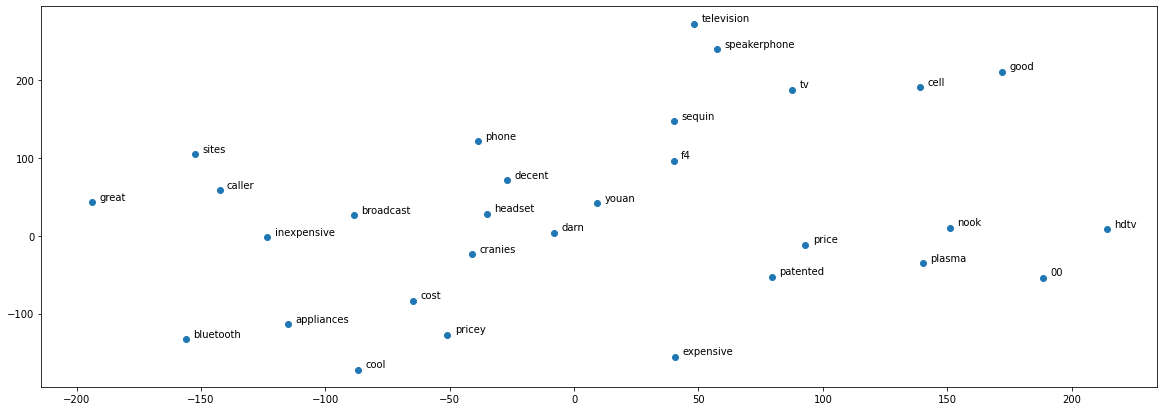

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

sample_vecs = word_vec.wv[set(word_bank)]
sample_tsne = tsne.fit_transform(sample_vecs)
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

f, axes = plt.subplots(figsize=(20,7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x+3, y+3))

plt.show()

In [40]:
word_vec.wv.most_similar(positive=["books", "away"], \
                      negative=[], topn=1)

[('nene', 0.4521656632423401)]

In [41]:
word_vec.wv.most_similar(positive=["cheap"], \
                      negative=["quality"], topn=1)

[('idecided', 0.37080246210098267)]

In [42]:
word_vec.wv.most_similar(positive=["tablet"], \
                      negative=["phone"], topn=1)

[('sumerian', 0.5322734713554382)]

In [43]:
df["reviewText"].iloc[1000]

'The salt has a nice flavor. I use only right before eating to help keep sodium levels down, you can actually taste it. A bit pricey though.'

In [44]:
#helpful = df["helpful"].tolist()
#most_helpful = max(helpful, key=lambda x: x[0])

#most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
#most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[1000]

print(most_helpful_text)

The salt has a nice flavor. I use only right before eating to help keep sodium levels down, you can actually taste it. A bit pricey though.


In [45]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load('en_core_web_sm')

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

CPU times: user 1.19 s, sys: 149 ms, total: 1.34 s
Wall time: 1.12 s


In [46]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)

In [47]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, jupyter=True, \
                    options={"compact": False, \
                             "distance": 90, \
                             "word_spacing":20, \
                             "arrow_spacing":10, \
                             "arrow_stroke": 2, \
                             "arrow_width": 5})

for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)

In [48]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

book 0.024891475
movie 0.018633772
read 0.013430553
one 0.011577942
like 0.009280627
CPU times: user 23.8 s, sys: 3.12 s, total: 27 s
Wall time: 26.3 s


In [49]:
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")


Topic 1:
 book, 0.024891475215554237
 movie, 0.018633771687746048
 read, 0.013430552557110786
 one, 0.011577942408621311
 like, 0.00928062666207552

Topic 2:
 book, 0.019734585657715797
 game, 0.01244143582880497
 good, 0.010772195644676685
 buy, 0.009079812094569206
 one, 0.009051885455846786

Topic 3:
 one, 0.017041346058249474
 get, 0.013931277208030224
 book, 0.009797263890504837
 good, 0.008195259608328342
 like, 0.006785660050809383

Topic 4:
 song, 0.014734857715666294
 like, 0.011292196810245514
 cd, 0.00981429498642683
 get, 0.00920144934207201
 love, 0.009055611677467823

Topic 5:
 product, 0.013517781160771847
 work, 0.013006732799112797
 use, 0.009826681576669216
 get, 0.009611119516193867
 buy, 0.00882069580256939

Topic 6:
 use, 0.018309615552425385
 get, 0.009265259839594364
 one, 0.00881969928741455
 great, 0.008385604247450829
 work, 0.008194828405976295

Topic 7:
 book, 0.030663350597023964
 like, 0.012607255950570107
 read, 0.0117713063955307
 one, 0.008686594665050

In [50]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)

In [51]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

[6585]


In [52]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

[]


In [53]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

'&#51204;&#49440; &#52964;&#53552;&#51032; &#50857;&#46020; &#51060;&#51648;&#47564; &#53356;&#44172; &#50416;&#51076;&#49464;&#44032; &#51080;&#50612; &#48372;&#51060;&#51648; &#50506;&#49845;&#45768;&#45796;.&#53945;&#55176; &#44405;&#51008; &#51204;&#49440;&#51060;&#45208; &#44592;&#53440; &#47932;&#52404;&#47484; &#51208;&#45800;&#54624;&#46412;&#45716; &#48324;&#47196;&#51060;&#45348;&#50836;.&#46608; &#44032;&#45140; &#45216;&#45180;&#47532; &#47582;&#47932;&#47140;&#49436; &#51096; &#45796;&#47932;&#50612; &#51648;&#51648;&#46020; &#50506;&#45348;&#50836;.'

In [54]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

Original 'model_df' count: 22500
Final 'model_df' count: 22499


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.603973,-0.348794,0.664079,-0.098483,0.586692,-0.308200,-0.458815,-0.255778,0.075951,0.019372,...,-1.098617,0.640073,0.059297,-0.066487,0.710698,-0.632541,-0.347338,0.252972,0.640434,4
1,0.632794,1.132696,0.278368,-2.137075,0.539395,-0.799886,0.490290,-0.905338,0.588994,1.129489,...,1.101161,1.529032,0.252435,-0.523153,0.755801,-0.152107,-1.495390,0.587513,-1.185823,5
2,0.156017,0.420537,-0.196524,0.087864,0.355906,-0.736868,-0.160480,0.202468,0.168596,0.089235,...,0.204631,1.787352,-0.418669,-0.323429,0.491798,0.185601,0.429085,0.237398,-0.199196,4
3,0.239347,-1.343680,-0.194223,0.067801,0.528924,-0.640471,0.111442,-0.318674,-0.280968,-1.093798,...,-0.712010,0.085350,-0.838187,-0.009815,0.012495,0.687888,0.871350,0.287600,0.821595,3
4,-0.775072,-0.099956,-0.775559,-0.006751,1.592749,0.136562,0.340273,0.673641,0.319021,0.923581,...,-0.345152,0.818701,0.283028,0.068460,0.425341,-0.589458,-1.440340,0.112281,-0.369435,5


In [55]:
model_df.label.value_counts()

1    4544
2    4539
5    4491
3    4471
4    4454
Name: label, dtype: int64

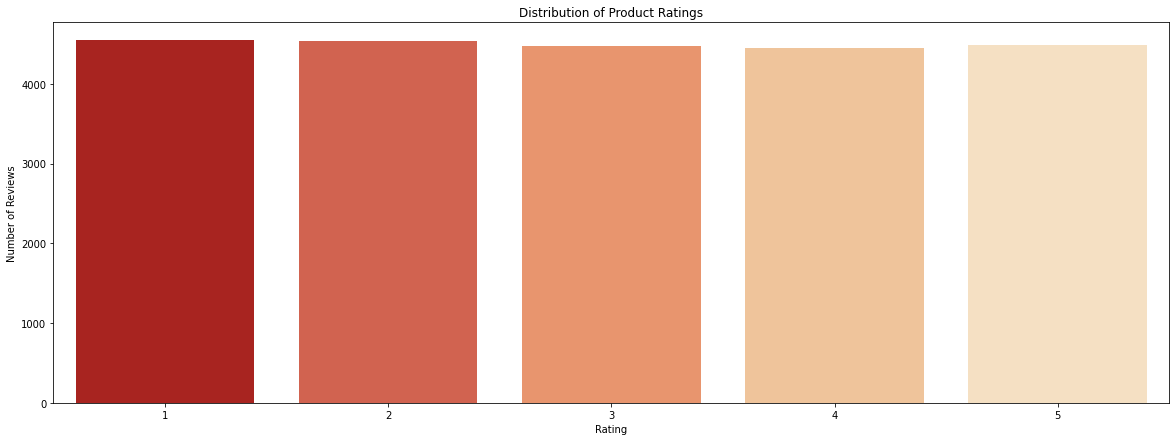

In [56]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [57]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

19.96%


In [58]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

Size of the most underrepresented class: 4539


In [59]:
 model_df["label"]

0        4
1        5
2        4
3        3
4        5
        ..
22495    3
22496    4
22497    4
22498    3
22499    5
Name: label, Length: 22499, dtype: int64

In [60]:
condition = model_df["label"] == 5

In [61]:
#trim the majority class
condition = model_df["label"] == 5.0
trimmed_df = model_df[condition].sample(n=count, random_state=42,replace=True)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 4539
Size of Class 2: 4539
Size of Class 3: 4471
Size of Class 4: 4454
Size of Class 5: 4539


In [62]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.tail())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
18363,-0.496287,0.189834,-1.415094,0.004556,0.557019,-0.813801,-0.026083,-0.185251,0.722876,0.875206,...,0.306653,0.268297,0.021708,-1.122625,-0.362535,0.017599,-0.665602,-0.434125,-0.435196,5
13419,0.216326,1.169122,-2.274304,-0.664725,0.864013,-0.166241,0.437359,1.488879,0.047524,0.874264,...,1.052388,-0.387351,0.458688,-0.498302,-1.419851,0.165291,1.188529,-0.728325,-0.503194,5
12046,1.452497,0.364071,-0.202759,-0.959050,1.129056,0.783143,1.396044,0.074494,0.788620,-0.282458,...,1.014223,0.615874,0.430831,1.533650,-0.044425,0.559326,0.873452,0.585415,0.048216,5
19255,-0.216428,-0.119213,-1.175895,0.008705,-0.086935,0.282572,0.863600,0.601618,0.045564,-0.279684,...,0.025152,-0.267809,0.586384,0.511199,0.149485,0.141181,0.465503,-0.595806,0.324411,5
4531,1.470665,-0.085344,0.820399,0.386081,0.811420,-0.010186,0.183771,1.144214,0.324152,0.786615,...,-0.216270,0.198308,-0.698274,0.577693,2.144033,-1.355743,-1.694375,-0.132411,-0.503241,5


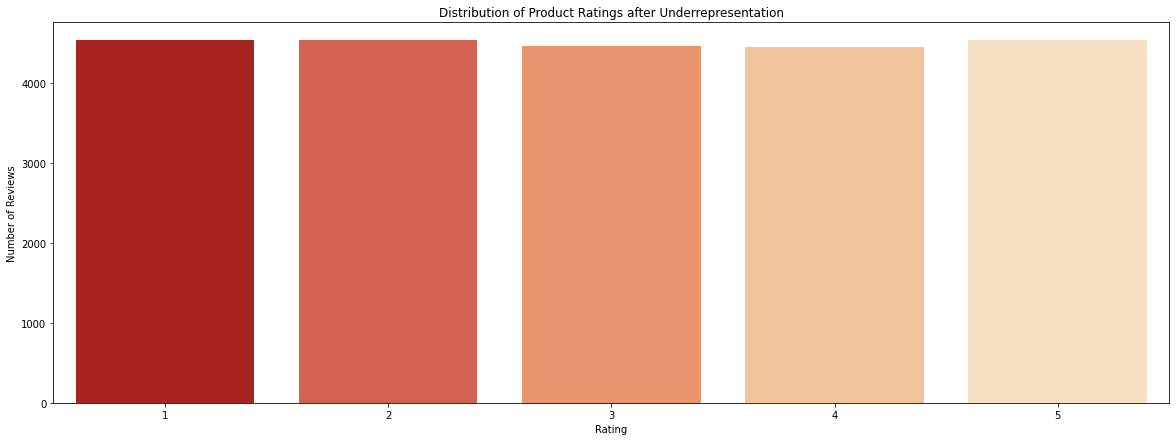

In [63]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [64]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [65]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

Baseline Accuracy: 20.131%
Baseline F1 Score: 0.201


In [66]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [67]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=2, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(ç)

CPU times: user 535 ms, sys: 14.9 ms, total: 550 ms
Wall time: 571 ms


RandomForestClassifier(bootstrap=True,
                       class_weight={1: 10, 2: 12, 3: 7, 4: 9, 5: 1},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

# Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(X_train, y_train.values.ravel())
scores = clr.score(X_train, y_train) # accuracy
print("Logistic Regression : " , scores)

Logistic Regression :  0.45169017833377695


# SVM

In [101]:
from sklearn import svm
# instantiate and train model, kernel=rbf 
svm_rbf = svm.SVC(random_state=12345)
svm_rbf.fit(X_train, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(X_train)
print(" SVM : ", y_pred_1)
def eval_predictions(y_test, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print ('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_test, y_pred, average='weighted'))
eval_predictions(y_test, y_pred_1)


 SVM :  [3 1 1 ... 2 5 2]
accuracy: 0.20042587170614853
precision: 0.20021287042292651
recall: 0.20042587170614853
F-measure: 0.1994606832858006


# Navie Bayes

In [ ]:
nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train)

In [100]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 63.987%
Training Set F1 Score: 0.640


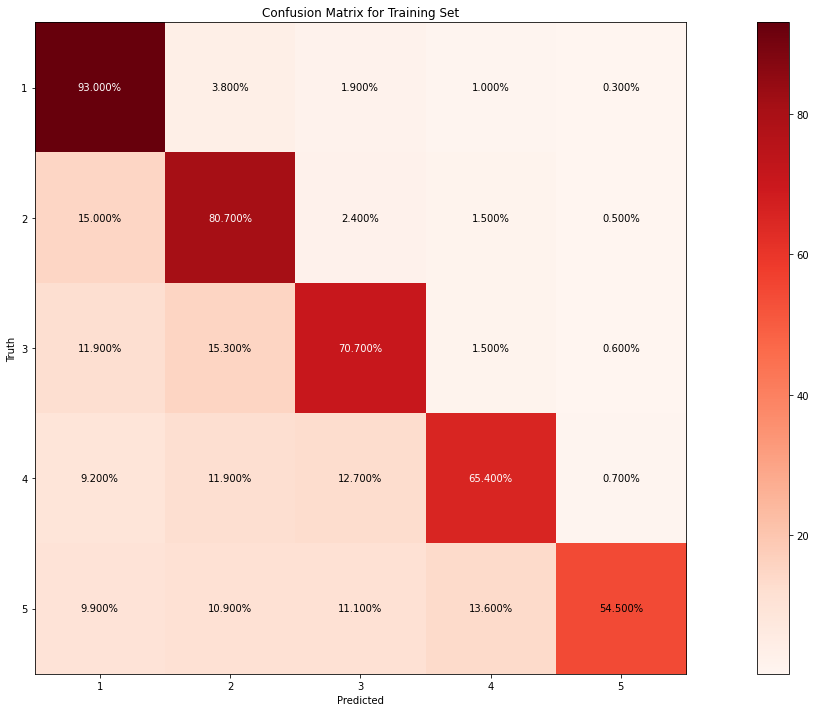

In [69]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [70]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="accuracy")
cross_val_f1 = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="f1_micro")

cross_val_accuracy = np.mean(cross_val_accuracy)
cross_val_f1 = np.mean(cross_val_f1)

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")
print(f"Training Set F1 Score: {cross_val_f1:.3f}")

Training Set Accuracy: 25.101%
Training Set F1 Score: 0.251


In [71]:
%%time
import xgboost as xgb

y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

parameters = {"max_depth": 4, "eta": 0.2, "silent": 1, \
              "objective": "multi:softprob", "num_class": 5}

boost = xgb.train(parameters, train_set, 100)

CPU times: user 3min 4s, sys: 1.07 s, total: 3min 6s
Wall time: 29.7 s


In [72]:
y_pred = boost.predict(train_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 71.371%
Training Set F1 Score: 0.714


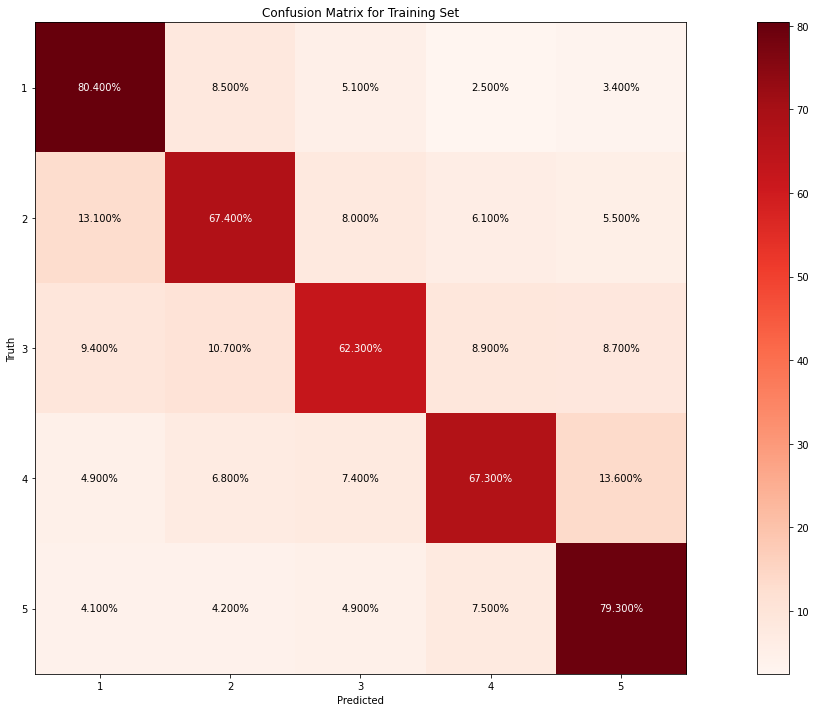

In [73]:
#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [74]:
%%time
boost_cv = xgb.cv(dtrain=train_set, params=parameters, nfold=3, \
                  num_boost_round=50, early_stopping_rounds=10, \
                  metrics="merror", as_pandas=True, seed=42)

display(boost_cv.head())

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.629618,0.006007,0.680427,0.003343
1,0.606839,0.004014,0.666370,0.000381
2,0.586838,0.001745,0.657536,0.006136
3,0.573893,0.001371,0.654425,0.001417
4,0.560920,0.003297,0.650091,0.003315


CPU times: user 3min 25s, sys: 1.31 s, total: 3min 26s
Wall time: 33.3 s


In [75]:
cross_val_accuracy = boost_cv.iloc[-1,2]
cross_val_accuracy = 1-cross_val_accuracy

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")

Training Set Accuracy: 40.313%


In [76]:
y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

Test Set Accuracy: 40.667%
Test Set F1 Score: 0.407


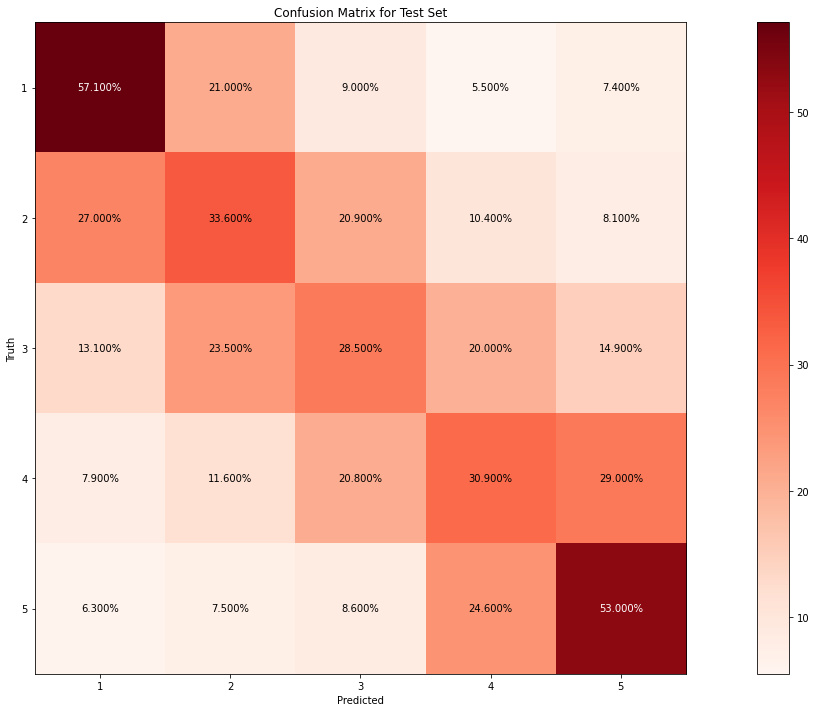

In [77]:
#create the confusion matrix of the test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [78]:
X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [79]:
y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Balanced Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Balanced Test Set F1 Score: {f1_score:.3f}")

Balanced Test Set Accuracy: 65.362%
Balanced Test Set F1 Score: 0.654


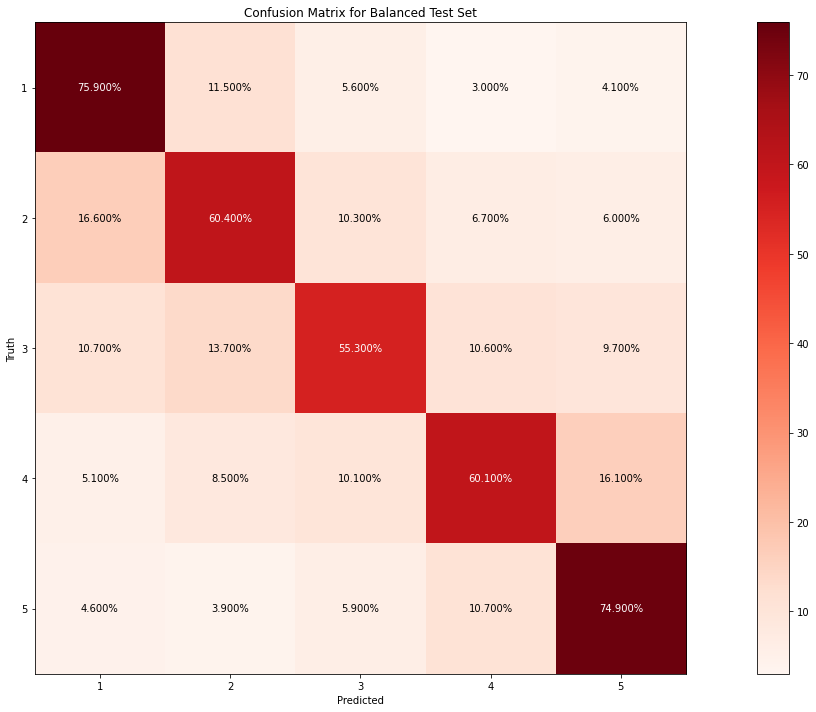

In [80]:
#create the confusion matrix of the balanced test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Balanced Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

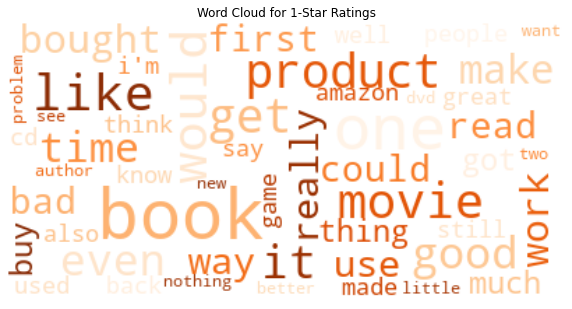

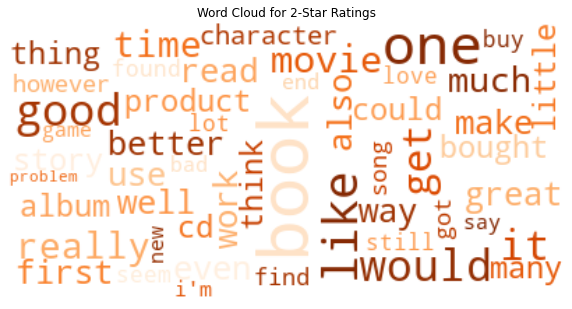

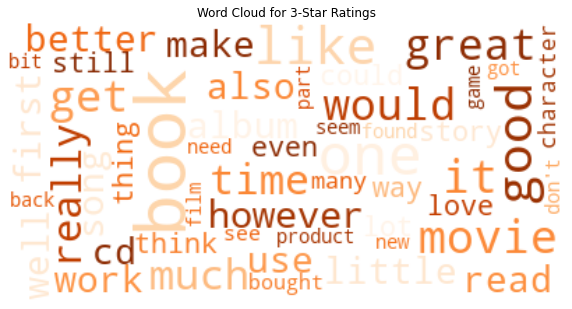

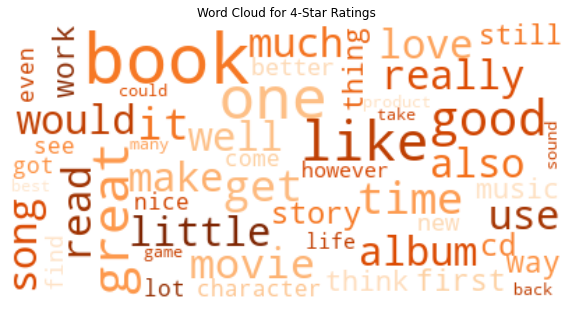

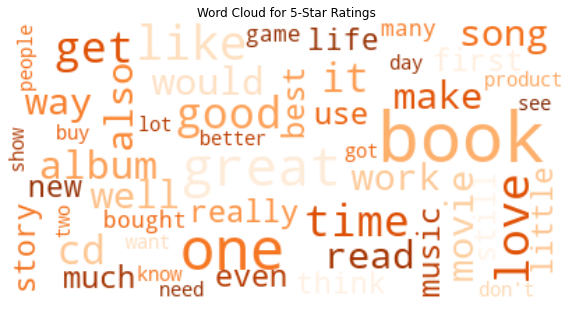

In [81]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = set(stop_words), min_font_size=10, \
                      max_font_size=50, max_words=50, \
                      background_color="white", colormap = "Oranges")

one_star_text = " ".join(df[df["overall"]==1]["reviewText"].values).lower()
two_star_text = " ".join(df[df["overall"]==2]["reviewText"].values).lower()
three_star_text = " ".join(df[df["overall"]==3]["reviewText"].values).lower()
four_star_text = " ".join(df[df["overall"]==4]["reviewText"].values).lower()
five_star_text = " ".join(df[df["overall"]==5]["reviewText"].values).lower()

text_list = [one_star_text, two_star_text, three_star_text, \
             four_star_text, five_star_text]

for index, text in enumerate(text_list):
    f, axes = plt.subplots(figsize=(10,7))
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star Ratings")
    plt.axis("off")
    plt.show()

In [82]:
df['overall'].unique()

array([4, 5, 3, 2, 1])

In [83]:
df['overall'].value_counts()

1    4544
2    4539
5    4491
3    4472
4    4454
Name: overall, dtype: int64

In [90]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression()
clr.fit(train_vector, trian_y.values.ravel())
scores = clr.score(test_vector, test_y) # accuracy
print(scores)

AttributeError: 'DataFrame' object has no attribute 'toarray'

NameError: name 'clf_list' is not defined

NameError: name 'X_train_vectorized' is not defined